In [17]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
import numpy as np
import seaborn as sns
import pandas as pd
df=pd.read_csv("Dataset/WorldEnergy.csv")

In [18]:
df

,Date,Total Fossil Fuels Production,Nuclear Electric Power Production,Total Renewable Energy Production,Total Primary Energy Production,Primary Energy Imports,Primary Energy Exports,Primary Energy Net Imports,Primary Energy Stock Change and Other,Total Fossil Fuels Consumption,Nuclear Electric Power Consumption,Total Renewable Energy Consumption,Total Primary Energy Consumption
0,1973-01-31,4.932632,0.068103,0.403981,5.404715,1.173080,0.125781,1.047299,0.771858,6.747651,0.068103,0.403981,7.223873
1,1973-02-28,4.729582,0.064634,0.360900,5.155115,1.168005,0.120883,1.047122,0.390129,6.163095,0.064634,0.360900,6.592366
2,1973-03-31,4.946902,0.072494,0.400161,5.419556,1.309473,0.139950,1.169523,-0.067640,6.044647,0.072494,0.400161,6.521439
3,1973-04-30,4.716271,0.064070,0.380470,5.160812,1.085169,0.194185,0.890984,-0.110067,5.493184,0.064070,0.380470,5.941729
4,1973-05-31,4.956995,0.062111,0.392141,5.411246,1.162804,0.196775,0.966029,-0.305335,5.613551,0.062111,0.392141,6.071940
...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,2022-07-31,6.921426,0.718109,1.132400,8.771935,1.907862,2.294320,-0.386458,0.199327,6.736891,0.718109,1.111161,8.584805
595,2022-08-31,7.047525,0.718526,1.044026,8.810077,1.821828,2.327090,-0.505262,0.225628,6.755154,0.718526,1.036589,8.530444
596,2022-09-30,6.915201,0.664673,0.978647,8.558521,1.702048,2.219831,-0.517784,-0.257997,6.144280,0.664673,0.960694,7.782741
597,2022-10-31,7.126618,0.614741,1.019209,8.760568,1.767733,2.322475,-0.554743,-0.394651,6.179721,0.614741,1.006859,7.811175


Exploratory Data Analysis


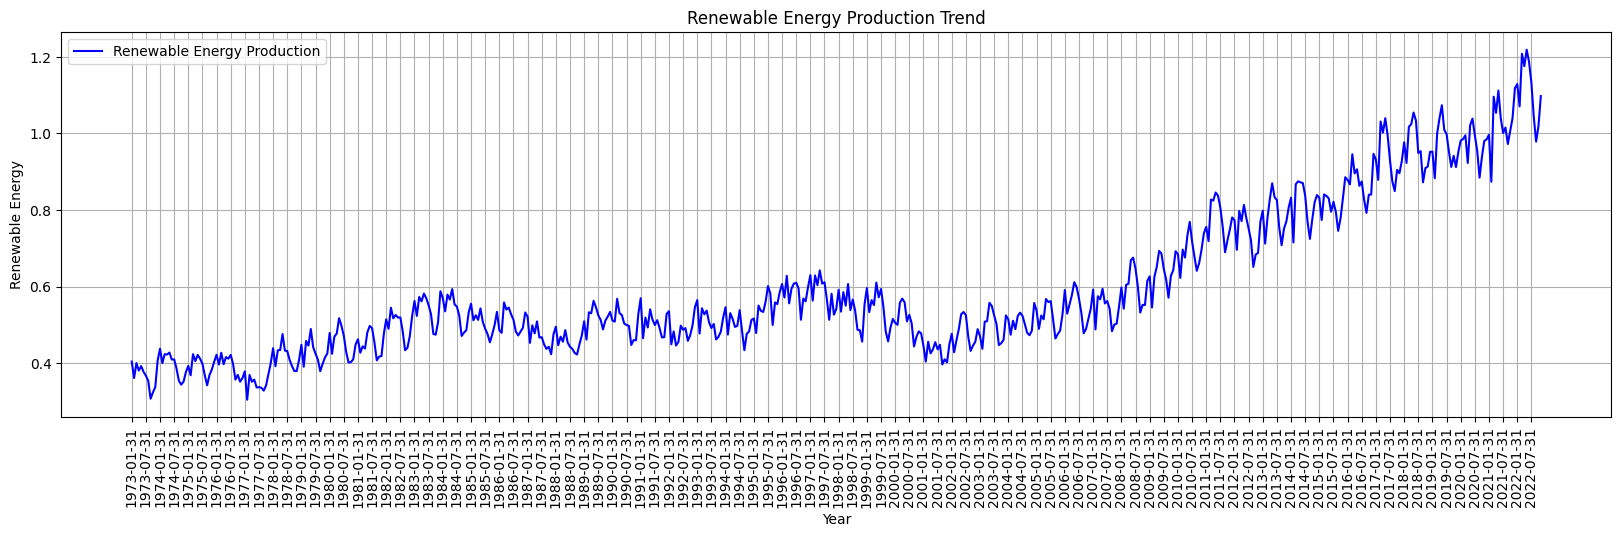

In [19]:
plt.figure(figsize=(20, 5))
plt.plot(df['Date'], df['Total Renewable Energy Production'], linestyle='-', color='b', label='Renewable Energy Production')
plt.xlabel('Year')
plt.ylabel('Renewable Energy')
plt.title('Renewable Energy Production Trend')
plt.xticks(df['Date'][::6], rotation=90)  # Ensure proper spacing and rotation
plt.legend()
plt.grid()
plt.show()


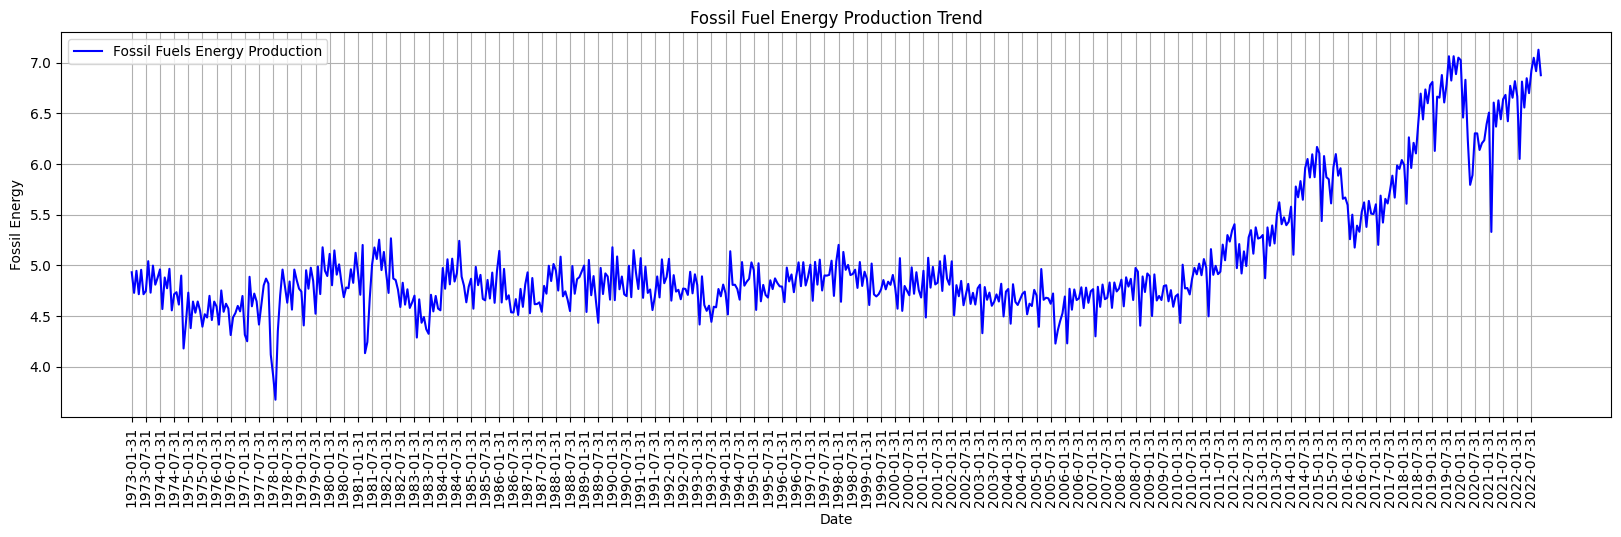

In [20]:
plt.figure(figsize=(20, 5))
plt.plot(df['Date'], df['Total Fossil Fuels Production'], linestyle='-', color='b', label='Fossil Fuels Energy Production')
plt.xlabel('Date')
plt.ylabel('Fossil Energy')
plt.title('Fossil Fuel Energy Production Trend')
plt.xticks(df['Date'][::6], rotation=90)  # Ensure proper spacing and rotation
plt.legend()
plt.grid()
plt.show()

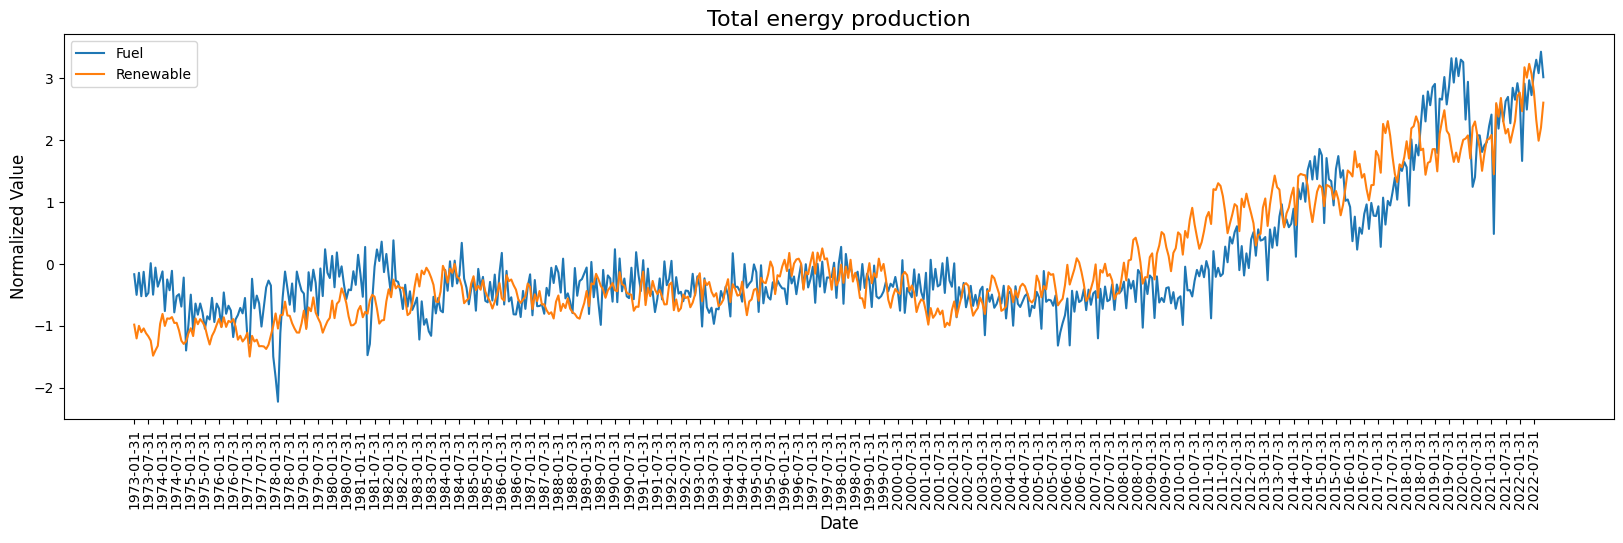

In [21]:
scaler=StandardScaler()
df['Normalized Fuel'] = scaler.fit_transform(df[['Total Fossil Fuels Production']])
df['Normalized Renewable'] = scaler.fit_transform(df[['Total Renewable Energy Production']])

plt.figure(figsize=(20, 5))
plt.plot(df['Date'], df['Normalized Fuel'], label="Fuel")
plt.plot(df['Date'], df['Normalized Renewable'], label="Renewable")
plt.title("Total energy production", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Normalized Value", fontsize=12)
plt.xticks(rotation=90)
plt.xticks(df['Date'][::6])  
plt.legend()
plt.show()

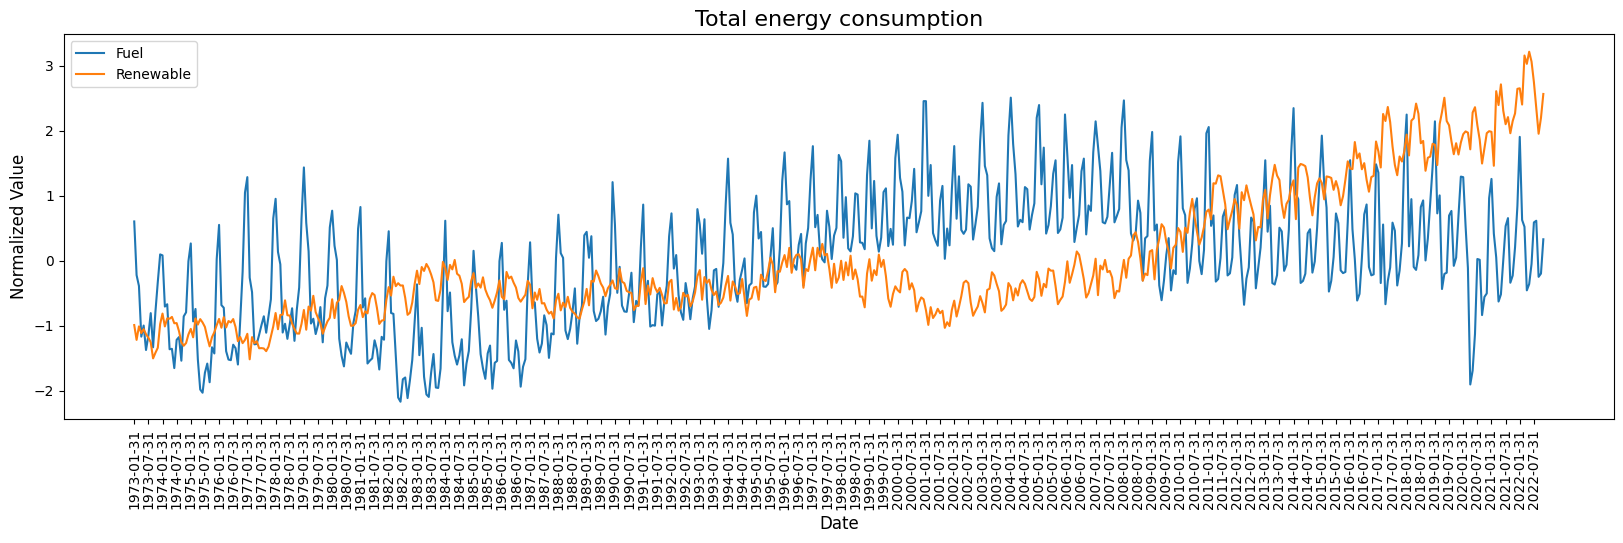

In [22]:
scaler=StandardScaler()
df['Normalized Fuel'] = scaler.fit_transform(df[['Total Fossil Fuels Consumption']])
df['Normalized Renewable'] = scaler.fit_transform(df[['Total Renewable Energy Consumption']])

plt.figure(figsize=(20, 5))
plt.plot(df['Date'], df['Normalized Fuel'], label="Fuel")
plt.plot(df['Date'], df['Normalized Renewable'], label="Renewable")
plt.title("Total energy consumption", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Normalized Value", fontsize=12)
plt.xticks(rotation=90)
plt.xticks(df['Date'][::6])  
plt.legend()
plt.show()

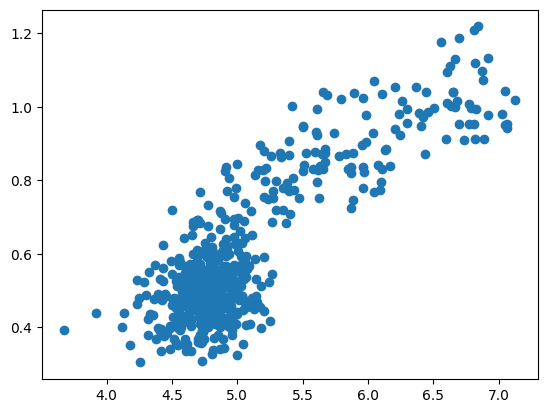

In [23]:
plt.scatter(df['Total Fossil Fuels Production'], df['Total Renewable Energy Production'])


In [24]:
correlation = df['Total Fossil Fuels Production'].corr(df['Total Renewable Energy Production'], method='pearson')

print(f"Pearson: {correlation:.3f}")


Pearson: 0.851


In [25]:
df["% Renewable"]= (df['Total Renewable Energy Production']+ df['Nuclear Electric Power Production'])/df['Total Primary Energy Production']*100

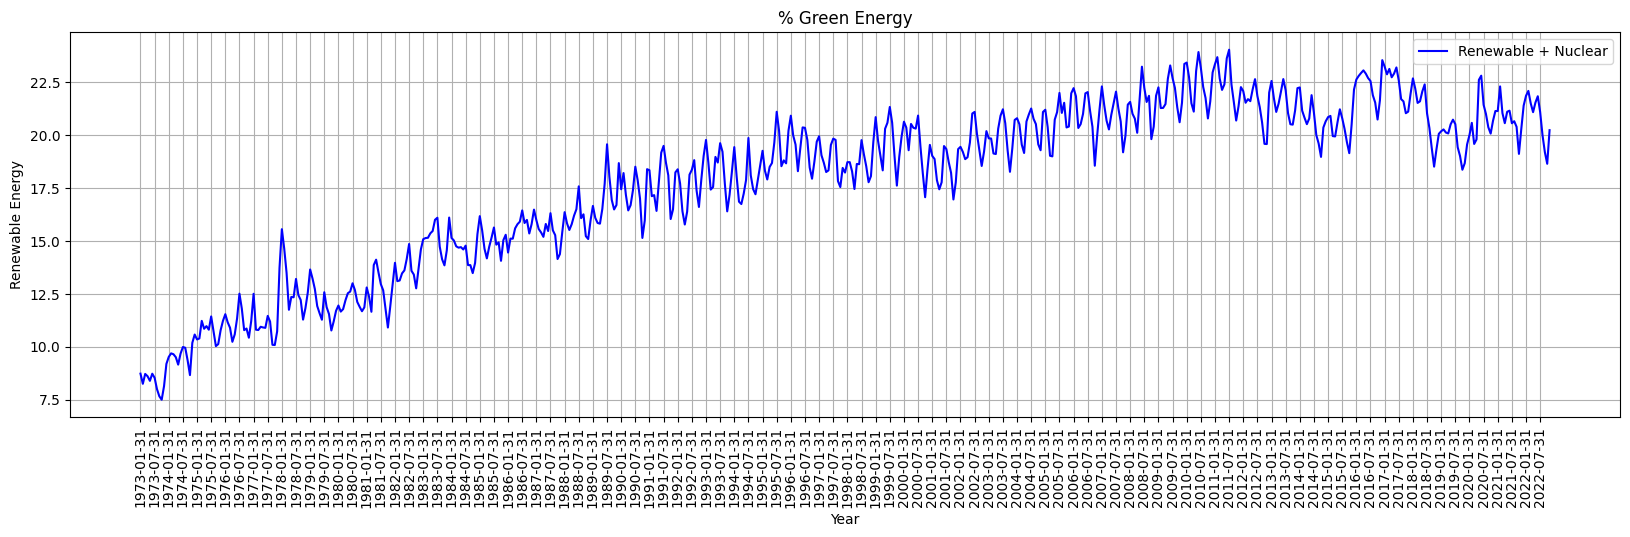

In [26]:
plt.figure(figsize=(20, 5))
plt.plot(df['Date'], df['% Renewable'], linestyle='-', color='b', label='Renewable + Nuclear')
plt.xlabel('Year')
plt.ylabel('Renewable Energy')
plt.title('% Green Energy')
plt.xticks(df['Date'][::6], rotation=90) 
plt.legend()
plt.grid()
plt.show()

Machine learning & statistics

In [27]:
#clustered the years based on the year-over-year changes in renewable energy production, identifying periods with similar growth patterns.

df['Renewable_YoY_Change'] = df['Total Renewable Energy Production'].diff()

kmeans = KMeans(n_clusters=4, random_state=42)

df_kmeans = df.dropna(subset=['Renewable_YoY_Change']).copy()
X = df_kmeans[['Renewable_YoY_Change']]

# Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df_kmeans['Cluster'] = kmeans.fit_predict(X)

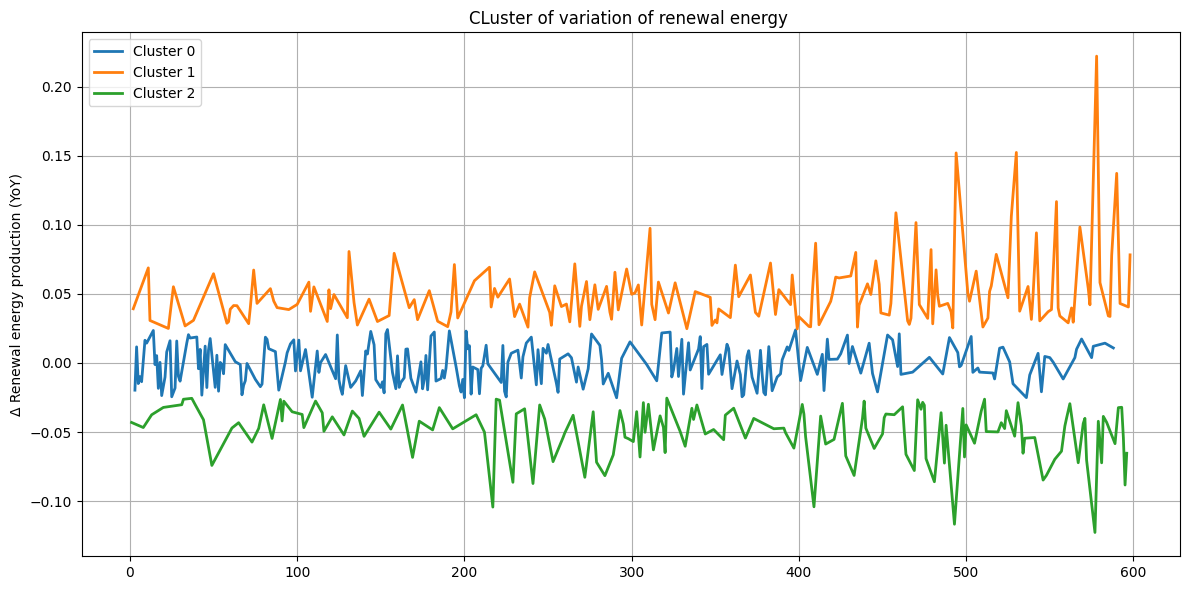

In [28]:
df_clusters = df_kmeans[['Date', 'Renewable_YoY_Change', 'Cluster']]

plt.figure(figsize=(12, 6))

for cluster_id in sorted(df_kmeans['Cluster'].unique()):
    cluster_data = df_kmeans[df_kmeans['Cluster'] == cluster_id]
    plt.plot( cluster_data['Renewable_YoY_Change'],
             label=f'Cluster {cluster_id}', linewidth=2)

plt.title('CLuster of variation of renewal energy ')
plt.ylabel('Δ Renewal energy production (YoY)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


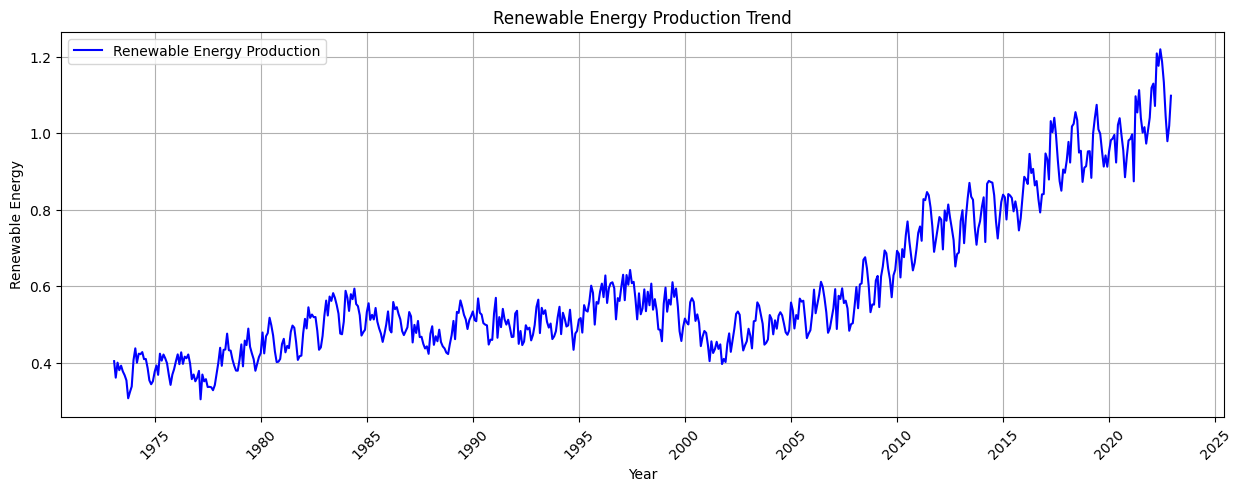

13:02:59 - cmdstanpy - INFO - Chain [1] start processing
13:02:59 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


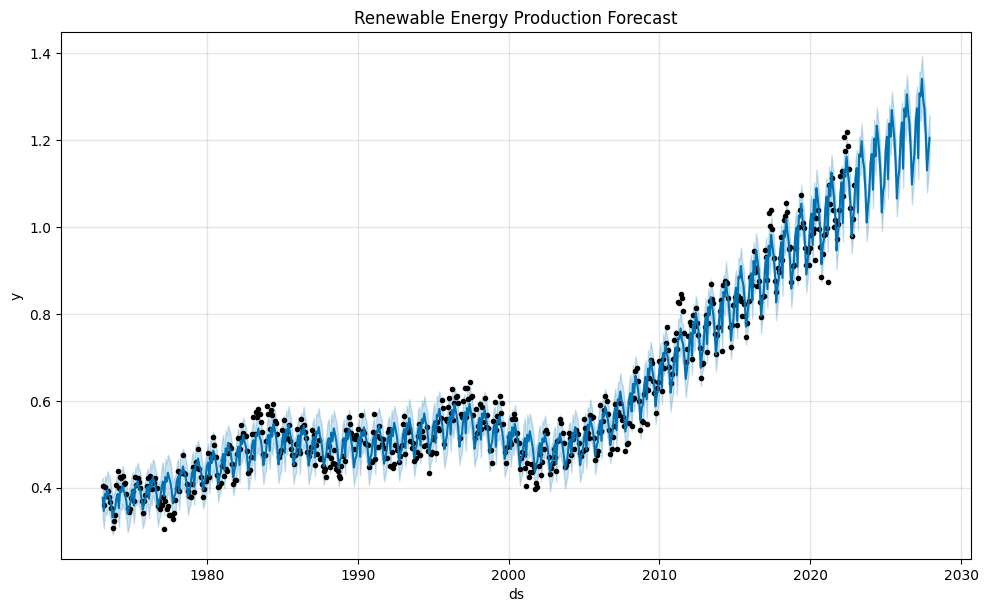

  0%|          | 0/45 [00:00<?, ?it/s]13:03:00 - cmdstanpy - INFO - Chain [1] start processing
13:03:00 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 1/45 [00:00<00:25,  1.75it/s]13:03:00 - cmdstanpy - INFO - Chain [1] start processing
13:03:01 - cmdstanpy - INFO - Chain [1] done processing
  4%|▍         | 2/45 [00:01<00:22,  1.94it/s]13:03:01 - cmdstanpy - INFO - Chain [1] start processing
13:03:01 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 3/45 [00:01<00:25,  1.63it/s]13:03:02 - cmdstanpy - INFO - Chain [1] start processing
13:03:02 - cmdstanpy - INFO - Chain [1] done processing
  9%|▉         | 4/45 [00:02<00:23,  1.72it/s]13:03:02 - cmdstanpy - INFO - Chain [1] start processing
13:03:03 - cmdstanpy - INFO - Chain [1] done processing
 11%|█         | 5/45 [00:03<00:25,  1.58it/s]13:03:03 - cmdstanpy - INFO - Chain [1] start processing
13:03:03 - cmdstanpy - INFO - Chain [1] done processing
 13%|█▎        | 6/45 [00:03<00:19,  2.02it/s]13:03:03

  horizon      mape      rmse       mae
0 83 days  0.065692  0.044742  0.035687
1 84 days  0.064942  0.044821  0.035724
2 85 days  0.068383  0.046838  0.037047
3 86 days  0.069834  0.047363  0.037758
4 87 days  0.070579  0.048087  0.038431


c:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
c:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


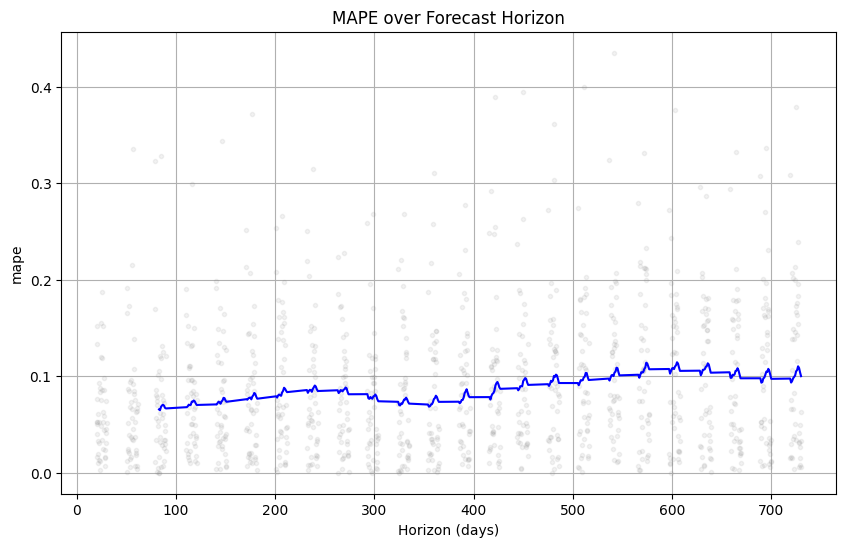

In [29]:
# Prophet forecasting on renewable energy production, with cross validation

# Pre-processing
df['Date'] = pd.to_datetime(df['Date'])  # Convert to datetime
df2 = df[['Date', 'Total Renewable Energy Production']].rename(
    columns={'Date': 'ds', 'Total Renewable Energy Production': 'y'}
)

# Trend visualization
plt.figure(figsize=(15, 5))
plt.plot(df2['ds'], df2['y'], linestyle='-', color='b', label='Renewable Energy Production')

plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xlabel('Year')
plt.ylabel('Renewable Energy')
plt.title('Renewable Energy Production Trend')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

# Prophet model training
model = Prophet(
    changepoint_prior_scale=0.05,  
    seasonality_mode='multiplicative',  
    seasonality_prior_scale=10 
)
model.fit(df2)

# Period of prediction
future = model.make_future_dataframe(periods=60, freq='M')
forecast = model.predict(future)

# Plotting prediction
model.plot(forecast)
plt.title("Renewable Energy Production Forecast")
plt.show()

# 6. Cross-validation (rolling forecasting origin)
df_cv = cross_validation(model,
                         initial='1200 days',   
                         period='365 days',     
                         horizon='730 days')    

# Metrics
df_perf = performance_metrics(df_cv)
print(df_perf[['horizon', 'mape', 'rmse', 'mae']].head())

# MAPE visualization
plot_cross_validation_metric(df_cv, metric='mape')
plt.title('MAPE over Forecast Horizon')
plt.show()


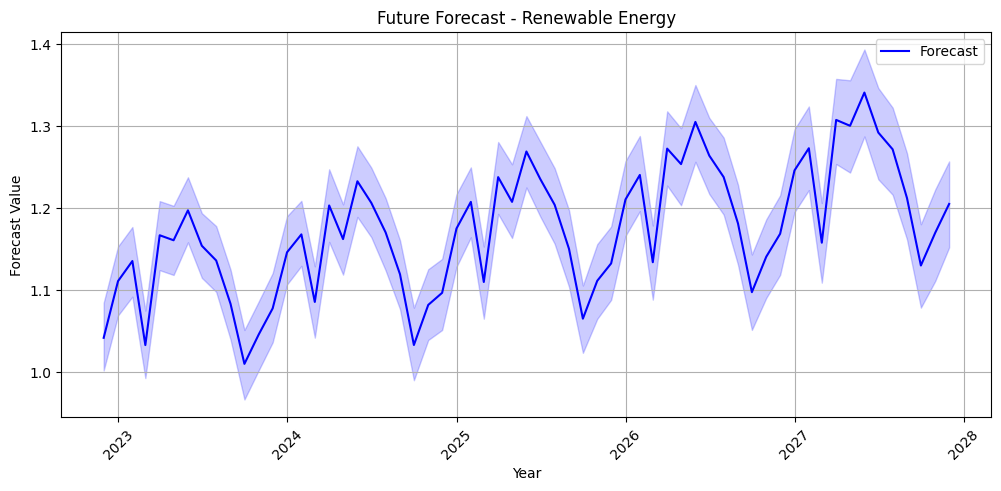

In [30]:
# Filter only future dates
future_forecast = forecast[forecast['ds'] >= df2['ds'].max()]

# Create the forecast plot
plt.figure(figsize=(12, 5))
plt.plot(future_forecast['ds'], future_forecast['yhat'], color='b', label='Forecast')
plt.fill_between(future_forecast['ds'], future_forecast['yhat_lower'], future_forecast['yhat_upper'], color='blue', alpha=0.2)

# Format the plot
plt.xlabel('Year')
plt.ylabel('Forecast Value')
plt.title('Future Forecast - Renewable Energy')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()